# Constructing empirical beam using catalogue of sources

This example uses a bunch of sources, extracted for images generated using a single day of IDR2.1 (2458115). We used the 4-closest point interpolation to form our system of linear equations:

\begin{align}
I^{obs} &= I^M(t_x, t_y, t_z).A_s(t_x, t_y, t_z) \\
        &= I^M\Bigg(\frac{\sum_{i=0}^4 b_iw_i(t_{x_i}, t_{y_i}, t_{z_i})}{\sum_{i=0}^4 w_i(t_{x_i}, t_{y_i}, t_{z_i})}\Bigg)
\end{align}

where $I^{obs}$ is the observed flux density of the sources observed by the instrument and ${I^M}$ is the model flux. Here, we are using our corrected flux density computed using

\begin{equation}
I^M = \frac{\sum_t I^{obs}.A_m(t)}{\sum_t A_m(t)^2}
\end{equation}
as our model flux. The caveat of using our own corrected flux is that we will only be able to constrain the beam model in the East-West direction.

## Loading HERA source catalogue

We found 120 sources that crosses HERA beam across the 42 snapshots generate from the single day observations.

In [48]:
%matplotlib notebook
import pylab as plt, numpy as np
import time
import linsolve
import pylab
from matplotlib import cm
import copy
import pickle
from collections import OrderedDict
import uvtools
import aipy

In [4]:
# loading hera source catalogue
pkl_file = pickle.load(open('srcdictxx.pkl'))
ras = pkl_file['ra']
decs = pkl_file['dec']
alts = pkl_file['alt']
azs = pkl_file['az']
has = pkl_file['ha']
peaks = pkl_file['peak']
corrfluxs = pkl_file['corrflux']
_sh = alts.shape
print _sh

(120, 42)


<IPython.core.display.Javascript object>


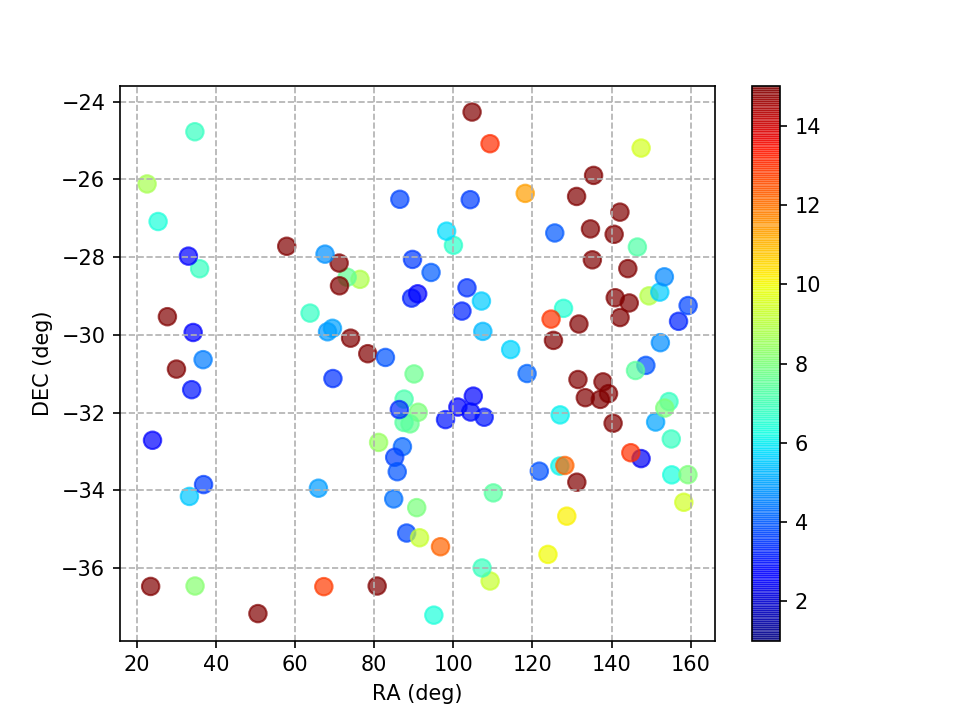

In [20]:
pylab.scatter(ras, decs, c = corrfluxs, marker='o', alpha=0.7, s=70, cmap='jet', vmin=1, vmax=15)
pylab.xlabel('RA (deg)')
pylab.ylabel('DEC (deg)')
pylab.grid(ls='dashed')
pylab.colorbar()

## Beam solving using simulations

We first try to reproduce the input beam model using simulations. We use a gaussian beam as our input beam model. We used the positions of the sources from the HERA catalogue and flux values are randomly generated.

<IPython.core.display.Javascript object>


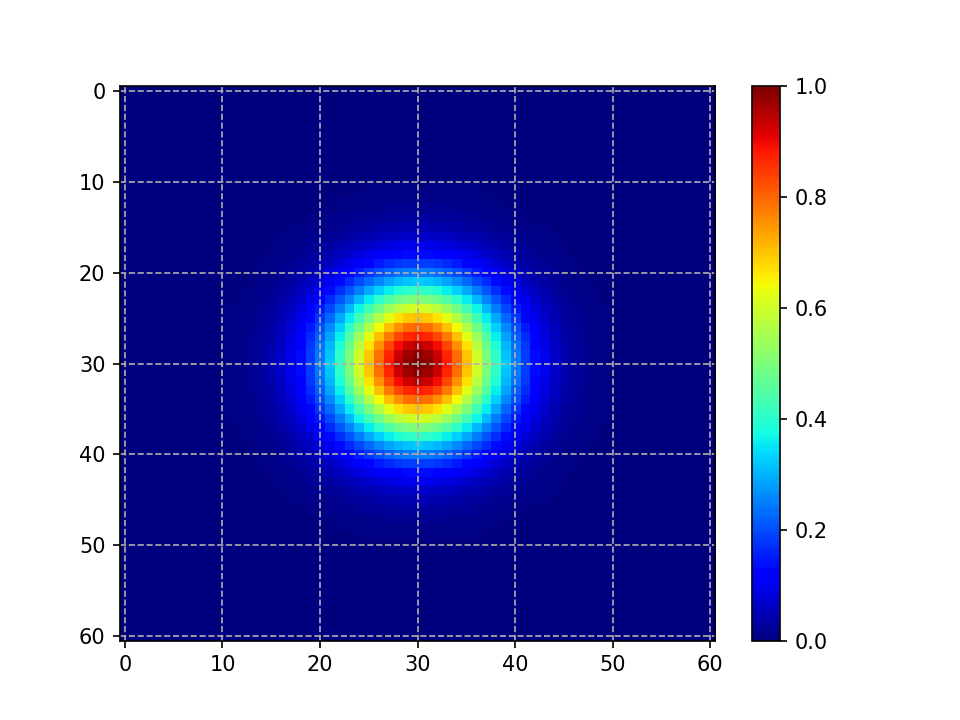

In [52]:
bm_pix = 61
bm_true = np.zeros((bm_pix, bm_pix), dtype=float)
bmx, bmy = np.indices(bm_true.shape)
mu = 30.; sigma=6.
bm_true = np.exp(-((bmx-mu)**2 + (bmy-mu)**2)/ (2 * sigma**2))

pylab.subplot(111)
im = pylab.imshow(bm_true, aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.colorbar(im)
pylab.grid(ls='dashed')

Generating topocentric corrdinates of the $61 \times 61$ grid.

In [45]:
def recenter(a, c):
    """Slide the (0,0) point of matrix a to a new location tuple c.  This is
    useful for making an image centered on your screen after performing an
    inverse fft of uv data."""
    s = a.shape
    c = (c[0] % s[0], c[1] % s[1])
    if np.ma.isMA(a):
        a1 = np.ma.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.ma.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    else:
        a1 = np.concatenate([a[c[0]:], a[:c[0]]], axis=0)
        a2 = np.concatenate([a1[:,c[1]:], a1[:,:c[1]]], axis=1)
    return a2

def get_LM(dim, center=(0,0), res=1):
        """Get the (l,m) image coordinates for an inverted UV matrix."""
        M,L = np.indices((dim, dim))
        L,M = np.where(L > dim/2, dim-L, -L), np.where(M > dim/2, M-dim, M)
        L,M = L.astype(np.float32)/dim/res, M.astype(np.float32)/dim/res
        mask = np.where(L**2 + M**2 >= 1, 1, 0)
        L,M = np.ma.array(L, mask=mask), np.ma.array(M, mask=mask)
        return recenter(L, center), recenter(M, center)

def get_top(dim, center=(0,0), res=1):
    """Return the topocentric coordinates of each pixel in the image."""
    x,y = get_LM(dim, center, res)
    z = np.sqrt(1 - x**2 - y**2)
    return x,y,z

In [46]:
tx0, ty0, tz0 = get_top(bm_pix, center=(int(mu), int(mu)), res=0.5)
tx00, ty00, tz00 = tx0.flatten(), ty0.flatten(), tz0.flatten()
indices = np.arange(bm_pix**2)
bm_true_f = bm_true.flatten()

Forming system of linear equations and using linsolve to solve for the unknowns. We used randomly generated flux values as our model flux values.

In [54]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

consts = OrderedDict()
eqs = OrderedDict()
interp2d = np.zeros((bm_pix**2))
fluxs = np.random.random(_sh[0]) + 10

time0 = time.time()
for i in range(_sh[0]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs[i,:]), np.deg2rad(alts[i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)#tx_px0 + 1
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)#ty_px0 + 1
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]

    for j in range(42):
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        A_s = (bm_true[tx_px0[j],ty_px0[j]] * w0[j] + bm_true[tx_px0[j],ty_px1[j]] * w1[j] + \
          bm_true[tx_px1[j],ty_px0[j]] * w2[j] + bm_true[tx_px1[j], ty_px1[j]] * w3[j])
        I_s = A_s * flux
        
        c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): flux * ws[p][j] for p in xrange(len(ps))}
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + \
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))]) 
        eqs[eq] = I_s 
        consts.update(c)

eqs_noise = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_noise, **consts)
sol = ls.solve(verbose=True)

interp2d = np.zeros((bm_pix**2))
for key in sol.keys():
    px = int(key.strip('b'))     
    interp2d[px] = sol.get(key)
        
print 'Time Elapsed: {} s'.format(time.time() - time0)

Solving 0/1
Time Elapsed: 2.41956400871 s


We are able to procude the portion of the beam model across the transit of the sources.

<IPython.core.display.Javascript object>


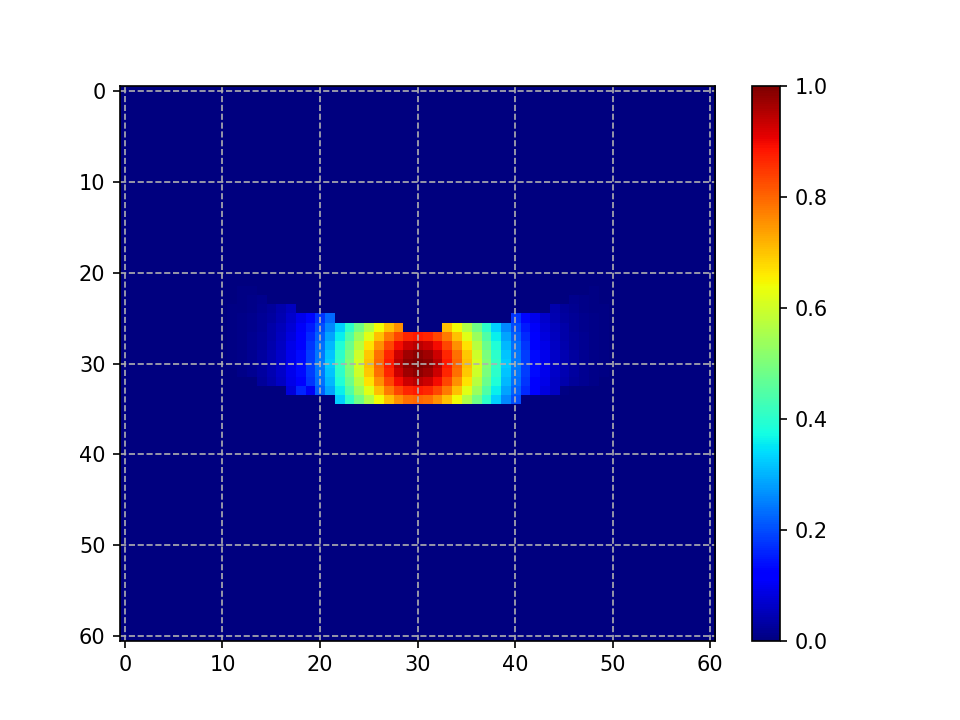

In [55]:
pylab.subplot(111)
im = pylab.imshow(np.abs(interp2d.reshape(bm_pix,bm_pix).T), aspect='auto', cmap='jet')
pylab.colorbar(im)
pylab.grid(ls='dashed')

## Beam solving using HERA observations

Forming system of linear equations and using linsolve to solve for the unknowns. We used the corrected fluxs of the sources as our flux model $I^M$ and the observed flux as $I^{obs}$.

In [56]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

consts = OrderedDict()
eqs = OrderedDict()
interp2d = np.zeros((bm_pix**2))

time0 = time.time()
for i in range(_sh[0]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs[i,:]), np.deg2rad(alts[i,:])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]
    
    for j in xrange(_sh[1]): 
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        flux = 0 if np.isnan(peaks[i,j]) else peaks[i,j]
        if alts[i,j]>=0:
            c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): 1 * ws[p][j] for p in xrange(len(ps))}
            eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + 
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))])
            eqs[eq] =  flux / corrfluxs[i]
            consts.update(c)

eqs_beam = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_beam, **consts)
sol = ls.solve(verbose=True)

for key in sol.keys():
    px = int(key.strip('b'))
    interp2d[px] = sol.get(key)

print 'Time Elapsed: {} s'.format(time.time() - time0)    

Solving 0/1
Time Elapsed: 2.06021690369 s


We are able to produce the beam to some extent. However, there seems to be some degenracies which might be likely due to fewer equations involving those variables (or pixels).

<IPython.core.display.Javascript object>


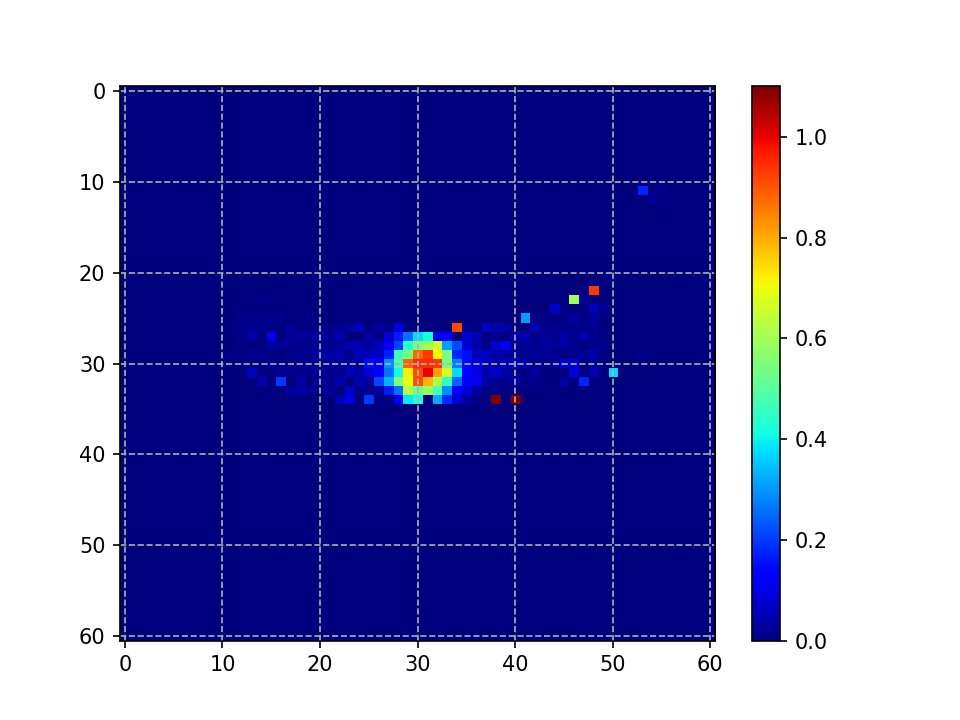

In [80]:
interp2d.shape = (bm_pix, bm_pix)
pylab.subplot(111)
pylab.imshow(interp2d.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.grid(ls='dashed')
pylab.colorbar()

### Treating degenaracies

The system of linear equations that we constructed can be represented as:
\begin{align}
y &= Ax\\
A^Ty &= A^TAx
\end{align}
We carry out singular value decomposition on the matrix $A^TA$ to identify and get rid of the degenerate emodes.

In [72]:
A = ls.get_A()
A.shape = (A.shape[0],A.shape[1])
AtA = np.dot(A.T.conj(),A)
U,S,V = np.linalg.svd(AtA)

<IPython.core.display.Javascript object>


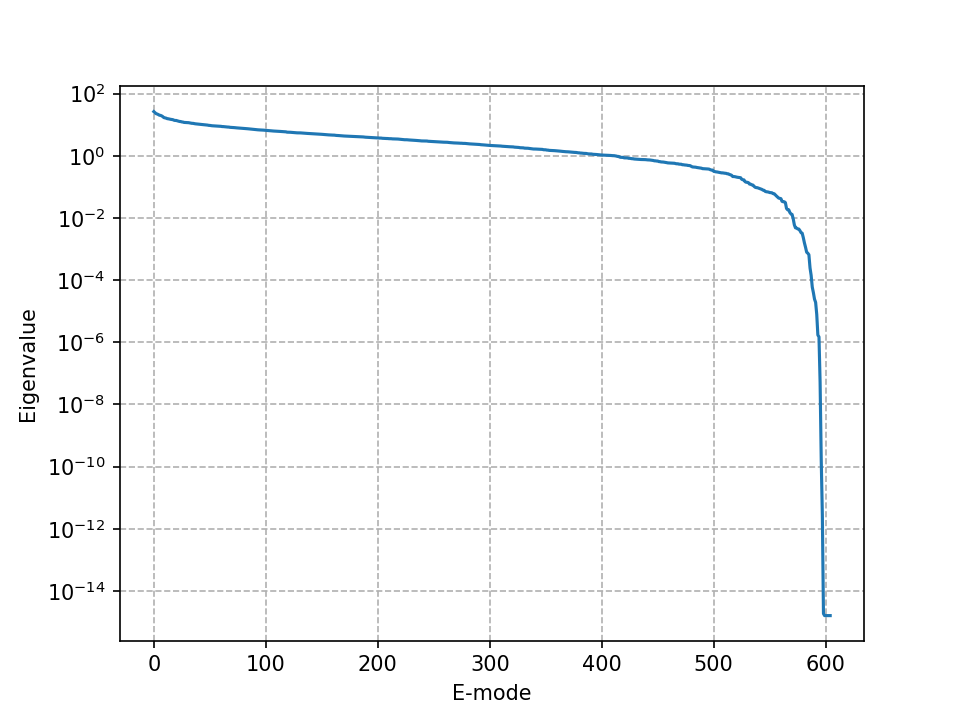

Text(0,0.5,'Eigenvalue')

In [73]:
plt.subplot(111)
plt.semilogy(S)
plt.grid(ls='dashed')
pylab.xlabel('E-mode')
pylab.ylabel('Eigenvalue')

We see that the emodes drastically drops around 550. In order to identify the emode cut we computed the contribution of each mode and rejected the emodes which less significant (< 0.002).

In [76]:
total = sum(S)
var_exp = np.array([(i / total)*100 for i in sorted(S, reverse=True)])
cum_var_exp = np.cumsum(var_exp) # cummalative 
cutoff_mode = np.where(var_exp <0.002)[0][0]

<IPython.core.display.Javascript object>


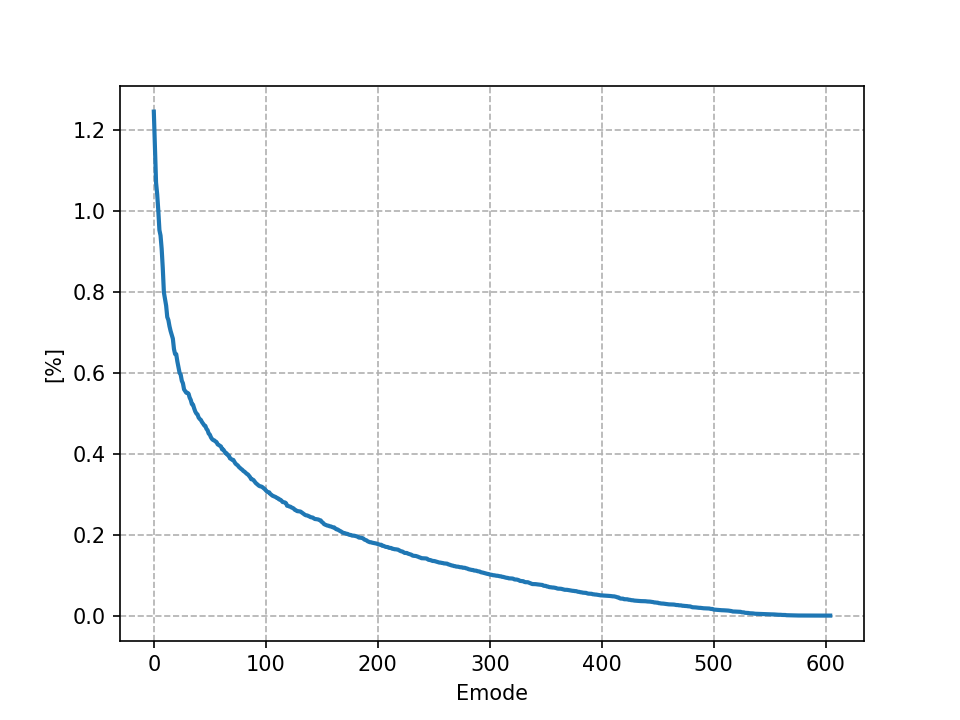

Text(0,0.5,'[%]')

In [75]:
pylab.subplot(111)
pylab.plot(var_exp, linewidth=2)
pylab.grid(ls = 'dashed')
pylab.xlabel('Emode')
pylab.ylabel('[%]')

In [78]:
emode = np.average(np.abs(np.array([U[ls.prm_order.get('b%d' % px,0), cutoff_mode:] for px in xrange(bm_pix**2)])), axis=-1)
emode.shape = (bm_pix,bm_pix)

<IPython.core.display.Javascript object>


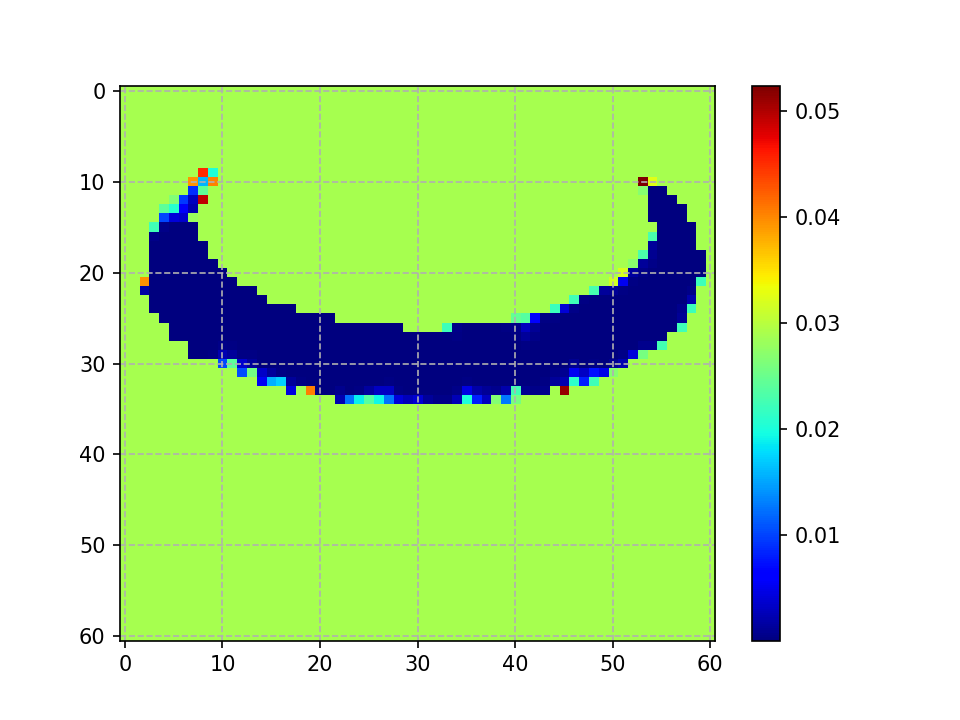

In [79]:
plt.subplot(111)
plt.imshow(emode.T, aspect='auto', cmap='jet')
plt.colorbar()
plt.grid(ls='dashed')

In [84]:
interp2d_copy = interp2d.copy()
for i in xrange(cutoff_mode, len(S)):
    emode = np.array([U[ls.prm_order['b%d' % px],i] if ls.prm_order.has_key('b%d' % px) else 0 for px in xrange(bm_pix**2)])
    emode.shape = (bm_pix,bm_pix)
    interp2d_copy -= np.sum(interp2d_copy * emode) * emode.conj()

<IPython.core.display.Javascript object>


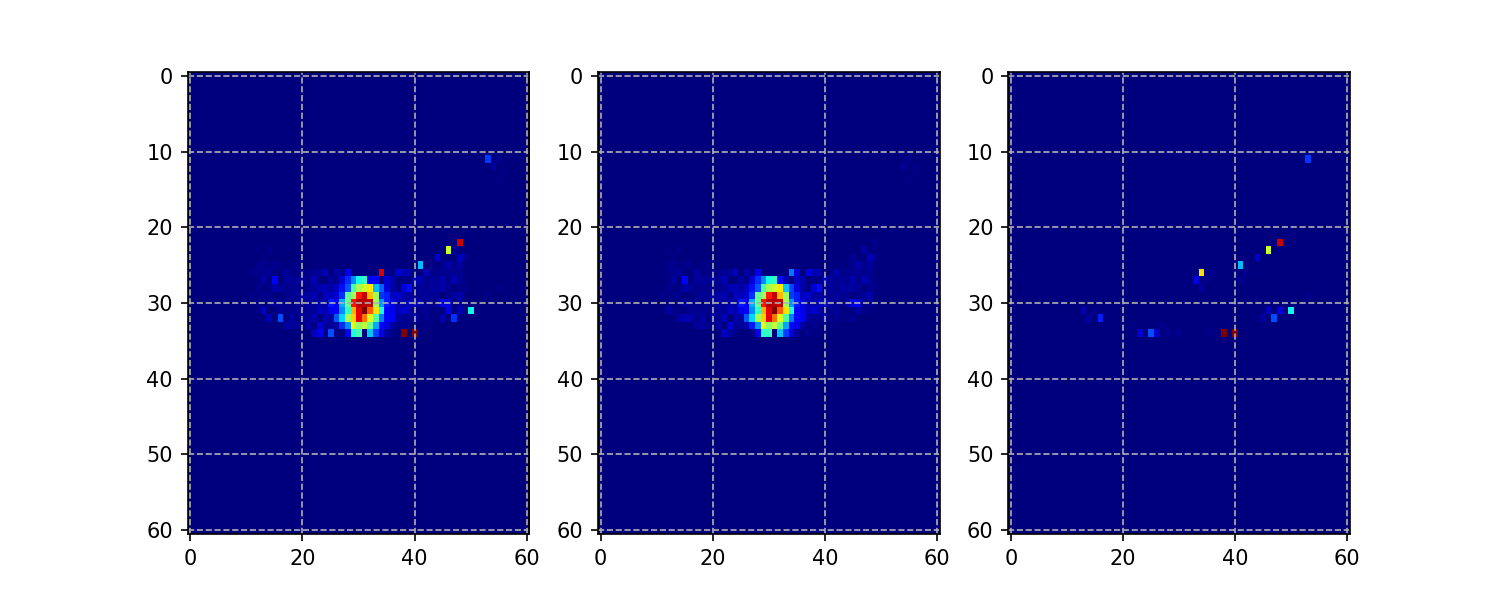

In [90]:
fig = pylab.figure(figsize=(10,4))
pylab.subplot(131)
pylab.imshow(interp2d.T, aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')

pylab.subplot(132)
pylab.imshow(interp2d_copy.T, aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')

pylab.subplot(133)
pylab.imshow((interp2d - interp2d_copy).T, aspect='auto', cmap='jet', vmin=0, vmax=1)
pylab.grid(ls='dashed')
